# Advanced Optimization Lab1: Background Modeling From Video
AOpt - Fall 2024

# 0. Welcome to the Lab!

In this experiment, we will be utilizing Python and Jupyter Notebook. Below, we provide a brief tutorial for those unfamiliar with these tools. If you have not used them before, please take some time to learn the basics on your own, as the teaching assistants will not answer questions related to programming languages and setting up the environment.


## 0.1 Jupyter Notebook Quick Guide

### Installation
1. Ensure that Python and pip (Python’s package installer) are installed on your system.
2. Install Jupyter Notebook using pip: ```pip install notebook```


### Starting Jupyter Notebook

You can directly launch Jupyter Notebook using software like VScode or Pycharm or you can open a web version of Jupyter Notebook using the following steps:
1. Open a terminal or command prompt.
2. Navigate to the directory where you want to start your notebook: ```cd your_directory_path```
3. Run the command: ```jupyter notebook```
4. Jupyter Notebook will start in your default web browser.

### Using Jupyter Notebook
- **Running a Cell**: Type your Python code into a cell, and press the run icon on the left side of the cell to run it.
- **Saving Your Work**: Click on "File" > "Save and Checkpoint" to save your notebook.


You can try running the following cell to see if the environment configuration is successful

In [10]:
1+2

3

## 0.2 Homework Requirements and Grading Criteria

### Submitting The Notebook
1. In the notebook, there are some code blocks that need you to complete. **These areas that require your attention will be marked with 'TODO'**.
2. When you have completed the entire experiment, please ensure that all code block outputs are correct. Export this ipynb file as an HTML file and make sure that the code block outputs (such as images) are displayed correctly in the HTML file. 
3. Finally, **submit this HTML file along with your assignment**.

That's it! You're ready to use Jupyter Notebook.

### Score
- 10/40: Complete all the missing code blocks and submit an HTML file with all the output results.
- 20/40: Draw a reasonable comparison of convergence rates between PG and APG (plot the curves of loss as the number of iterations increases for both algorithms). You can refer to the image below.


  <p align="center">
  <img src="ref_fig.png" width="600"/>
  </p>

  
- 30/40: By the 50th round, the loss outputted by the APG algorithm has reached < 5e6.
- 40/40: By the 50th round, the loss outputted by the APG algorithm has reached < 4e6.

## 0.3 Importing The Package
Please install the required packages in the following cell and run the cell below to import these packages. __Note that it is not allowed to add any additional packages or function__.

In [11]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tqdm
%matplotlib inline

# 1. Background

Before diving into the problems, it's essential to review the composition optimization part in Lecture 4. Once you've thoroughly understood the content, you can begin tackling the challenges, referring back to the lecture material whenever necessary.

In the lecture, we delved into the PG (Proximal Gradient) algorithm and the APG (Accelerated Proximal Gradient) algorithm. This lab will take those concepts and apply them to an engaging task: **background modeling from video**. Video is a natural candidate for low-rank modeling, due to the correlation between frames.

### Problem Formulation

Suppose we are given a data matrix $D\in\mathbb{R}^{m\times d}$, which is expected to be decomposed as

$$D = L_0 + S_0$$  
  
where $L_0 \in \R^{m\times d}$ has low rank and $S_0 \in \R^{m \times d}$ is sparse. For example, if the data matrix $D$ represents a sequence of frames from a monitoring video, the background variations $L_0$ can be modeled as a low-rank structure because of the correlation across frames, while moving foreground objects $S_0$ can be represented as sparse components.

To achieve this goal, we formulate the following optimization problem:

$$\min_{L, S\in\mathbb{R}^{m\times d}} \frac{1}{2}\Vert D - L - S \Vert_\text{F}^2 + \mu \Vert L \Vert_* + \lambda \Vert S \Vert_1
\tag{1}$$

where $\mu,\lambda>0$ are hyperparameters, $\|A\|_*=\sum_{i}\sigma_i(A)=\text{tr}(\sqrt{A^\top A})$ denotes the nuclear norm to impose the low-rank requirement on the matrix $A$, and $\| A \|_1=\sum_{ij}|A_{ij}|$ denotes the $\ell_1$-norm to impose the sparsity requirement on the matrix $A$.

### Composite Optimization

To solve $(1)$, we can convert it into a composite optimization problem, where the optimization variable is $\mathbf{X} \triangleq (X^L, X^S)\in\mathbb{R}^{m\times d}\times \mathbb{R}^{m\times d}$ and the corresponding composite functions are  $f(\mathbf{X})=\frac{1}{2}\Vert D - X^L - X^S \Vert_\text{F}^2$ and $h(\mathbf{X})=\mu \Vert X^L \Vert_* + \lambda \Vert X^S \Vert_1$. Now the optimization problem becomes

$$\min_{\mathbf{X}\in\mathbb{R}^{m\times d}\times \mathbb{R}^{m\times d}} f(\mathbf{X}) + h(\mathbf{X}).
\tag{2}$$

Note that both $f(\cdot)$ and $h(\cdot)$ are convex, and $f(\cdot)$ is $L_f$-smooth w.r.t. the $\|\cdot\|$ norm (i.e. $\|\mathbf{X}\|\triangleq\sqrt{\|X^L\|_{\text{F}}^2+\|X^S\|_{\text{F}}^2}$).

In this lab, you will implement the PG and APG algorithms to address the composite optimization problem $(2)$ for background modeling from video.

# 2. Monitoring Video Data

In this lab, we will work with the first $m=200$ video frames from the [Mall Dataset](https://personal.ie.cuhk.edu.hk/~ccloy/downloads_mall_dataset.html). To ensure the experiments can run effortlessly on a standard PC, each frame is converted to grayscale and resized to $128\times 96$. After preprocessing, every frame is flattened into a vector of length $d=12288$. These vectors are then sequentially organized into a data matrix $D\in\mathbb{R}^{m\times d}$.

The code cell below implements the described process along with a simple function, `show_imgs`, to display images. Simply run the cell to view examples of the video frames.

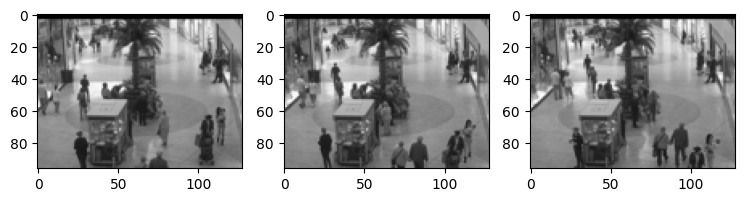

In [12]:
data_path, img_size = 'data', (128, 96)
m, d = 200, 12288

D = np.zeros((m, d))
for i in range(m):
    img = Image.open(os.path.join(data_path, f'seq_000{(i+1)//100}{(i+1)//10%10}{(i+1)%10}.jpg')).convert('L')
    img = img.resize(img_size)
    D[i] = np.array(img).flatten()

def show_imgs(*imgs):
    num = len(imgs)
    plt.figure(figsize=(3 * num, 4))
    for i in range(num):
        img = imgs[i].reshape((img_size[1], img_size[0]))
        plt.subplot(1, num, i+1)
        plt.imshow(img.astype(np.uint8), cmap='gray')
    plt.show()

show_imgs(D[0], D[1], D[2])

# 3. Background Modeling From Video

We are now prepared to tackle the problem of background modeling from video. By converting it into a composite optimization problem, you can apply both the Proximal Gradient (PG) algorithm and the Accelerated Proximal Gradient (APG) algorithm to optimize the objective function.

In this section, you are required to fill in certain code blocks marked with 'TODO'.

## 3.1 Implement Algorithm

### The Proximal Mapping

Both the PG algorithm and the APG algorithm need the **proximal mapping** $\textbf{prox}$ as a basic operator. Fortunately, in this experiment, solving 

$$
X=(X^L, X^S)=\text{prox}_{\frac{1}{L_f}h}(G)=\text{prox}_{\frac{1}{L_f}h}((G^L, G^S))
$$

has a simple and closed-form expression. We have already implement the $\textbf{prox}$ operator for you.

In [13]:
def Prox(G_L : np.ndarray,
         G_S : np.ndarray,
         L_f : float,
         mu : float,
         lamda : float):
    '''
    Solving the proximal mapping $X = prox_{h/L_f}(G)$

    :param G_L: first element of ordered pair G
    :param G_S: second element of ordered pair G
    :param L_f: parameter
    :param mu: parameter in h
    :param lamda: parameter in h

    :return X_L, X_S: the proximal mapping operation result
    '''
    
    def Soft_Thresholding(X, eps):
        return np.maximum(X - eps, 0.) + np.minimum(X + eps, 0.)
    
    U, S, Vh = np.linalg.svd(G_L, full_matrices=False)
    X_L = np.dot(U, np.dot(np.diag(Soft_Thresholding(S, mu / L_f)), Vh))
    X_S = Soft_Thresholding(G_S, lamda / L_f)
    
    return X_L, X_S

### The Objective Function

Please **fill in the content for TODO in the code block below** to implement the objective function $F\triangleq f + h$.

In [14]:
def loss_fn(D : np.ndarray,
            X_L : np.ndarray,
            X_S : np.ndarray,
            mu : float,
            lamda: float):
    '''
    Calculating the objective function $F(X) = f(X) + h(X)$

    :param D: the data matrix
    :param X_L: first element of ordered pair X
    :param X_S: second element of ordered pair X
    :param mu: parameter in h
    :param lamda: parameter in h

    :return loss: the objective function value
    '''
    # TODO your code here
    
    # F(X) = (1/2)||D - X_L - X_S||_F^2 + mu||X_L||_* + lambda||X_S||_1
    
    # 计算f(X)部分: (1/2)||D - X_L - X_S||_F^2
    f = 0.5 * np.sum((D - X_L - X_S) ** 2)
    
    # 计算h(X)中的核范数部分: mu||X_L||_*
    U, S, Vh = np.linalg.svd(X_L, full_matrices=False)
    h1 = mu * np.sum(S)
    
    # 计算h(X)中的L1范数部分: lambda||X_S||_1
    h2 = lamda * np.sum(np.abs(X_S))
    
    return f + h1 + h2
    return None

### PG Implement

Please **fill in the content for TODO in the code block below** to implement the single-step update part of the PG algorithm.

In [15]:
class PG:
    def __init__(self, D, L_f, mu, lamda, prox):
        self.D = D
        self.L_f = L_f
        self.mu = mu
        self.lamda = lamda
        self.prox = prox
        self.X_L, self.X_S = np.zeros_like(D), np.zeros_like(D) # optimization variable X
        self.loss_list = []
    
    def update(self):
        # single-step update X
        # %%
        # TODO your code here
        #
        #
        #
        # %%
        grad_L = self.X_L + self.X_S - self.D  # ∇_L f(X)
        grad_S = self.X_L + self.X_S - self.D  # ∇_S f(X)
    
        # 进行梯度步骤
        G_L = self.X_L - (1.0/self.L_f) * grad_L
        G_S = self.X_S - (1.0/self.L_f) * grad_S
    
        # 应用proximal算子
        self.X_L, self.X_S = self.prox(G_L, G_S, self.L_f, self.mu, self.lamda)

        # record the loss at this iteration
        self.loss_list.append(loss_fn(self.D, self.X_L, self.X_S, self.mu, self.lamda))
        
        return None

### APG Implement

Please **fill in the content for TODO in the code block below** to implement the single-step update part of the APG algorithm.

In [16]:
class APG:
    def __init__(self, D, L_f, mu, lamda, prox):
        self.D = D
        self.L_f = L_f
        self.mu = mu
        self.lamda = lamda
        self.prox = prox
        self.X_L, self.X_S = np.zeros_like(D), np.zeros_like(D) # optimization variable X
        self.Y_L, self.Y_S = np.zeros_like(D), np.zeros_like(D) # optimization variable Y
        self.loss_list = []
        self.lambda_ = 1. # iteration variable you may use

    def update(self):
        # single-step update X and Y
        # %%
        # TODO your code here
        #
        #
        #
        # %%
        X_L_old = self.X_L.copy()
        X_S_old = self.X_S.copy()
        lambda_old = self.lambda_
    
        # 计算新的lambda
        self.lambda_ = (1 + np.sqrt(1 + 4 * lambda_old**2)) / 2
    
        # 计算动量系数
        gamma = (lambda_old - 1) / self.lambda_
    
        # 计算Y的梯度
        grad_Y_L = self.Y_L + self.Y_S - self.D
        grad_Y_S = self.Y_L + self.Y_S - self.D
    
        # 进行梯度步骤
        G_L = self.Y_L - (1.0/self.L_f) * grad_Y_L
        G_S = self.Y_S - (1.0/self.L_f) * grad_Y_S
    
        # 应用proximal算子更新X
        self.X_L, self.X_S = self.prox(G_L, G_S, self.L_f, self.mu, self.lamda)
    
        # 更新Y(外推步骤)
        self.Y_L = self.X_L + gamma * (self.X_L - X_L_old)
        self.Y_S = self.X_S + gamma * (self.X_S - X_S_old)
    

        # record the loss at this iteration
        self.loss_list.append(loss_fn(self.D, self.X_L, self.X_S, self.mu, self.lamda))
        
        return None

## 3.2 Hyperparameters

In this experiment, we fix $\mu = \Vert D \Vert_2 * 10^{-4}$ and $\lambda = \Vert D \Vert_2 * 10^{-6}$, and set optimization epoch as $T=50$. The smoothness parameter **$L_f$** can be calculated since $f(\cdot)$ is given to you.  
Please **fill in the content for TODO in the code block below** to implement the smoothness parameter **$L_f$**.

In [17]:
T = 50
# mu = np.linalg.matrix_norm(D, ord=2) * 1e-4
# lamda = np.linalg.matrix_norm(D, ord=2) * 1e-6
mu = np.linalg.norm(D, ord=2) * 1e-4
lamda = np.linalg.norm(D, ord=2) * 1e-6
# calculate the smoothness parameter L_f
# %%
# TODO your code here
# L_f = 0.
# %%
L_f = 2

## 3.3 Experiment Result

You are now ready to run the algorithms and observe the performance of both PG and APG!

Epoch 0, loss-APG = 38509639.156, loss-PG = 38509639.156:   0%|          | 0/50 [00:01<?, ?it/s]

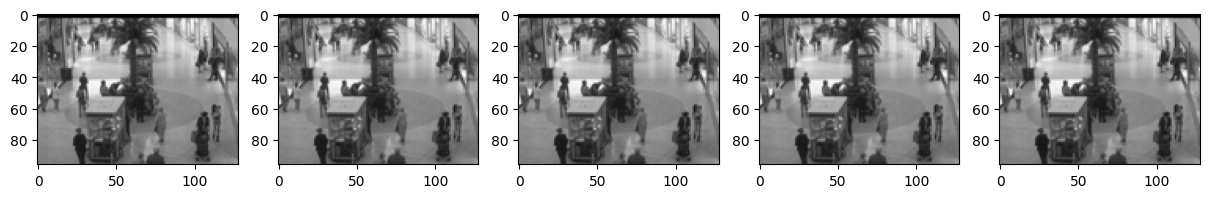

Epoch 10, loss-APG = 37532759.581, loss-PG = 38068644.870:  20%|██        | 10/50 [00:18<01:04,  1.61s/it]

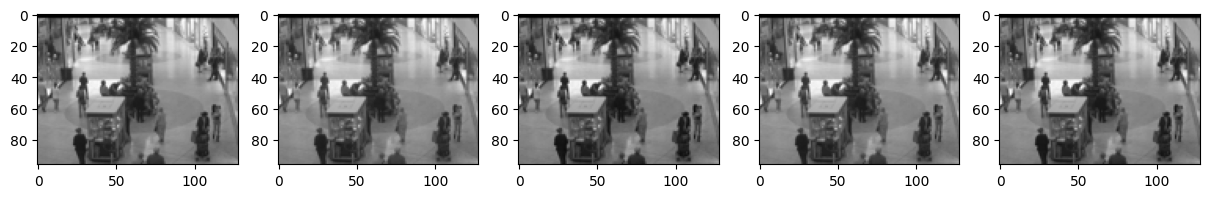

Epoch 20, loss-APG = 35430060.549, loss-PG = 37628302.577:  40%|████      | 20/50 [00:35<00:49,  1.63s/it]

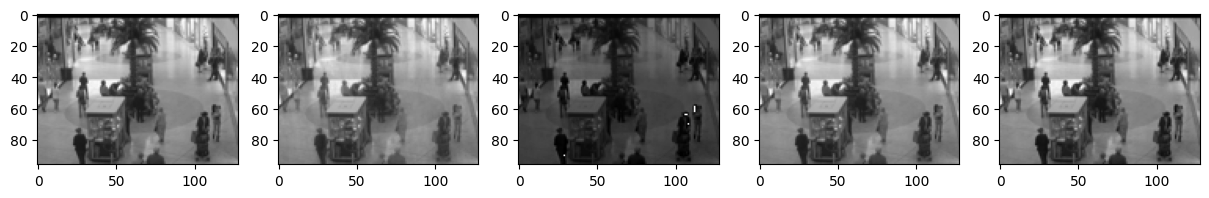

Epoch 30, loss-APG = 32773809.093, loss-PG = 37188425.609:  60%|██████    | 30/50 [00:51<00:32,  1.63s/it]

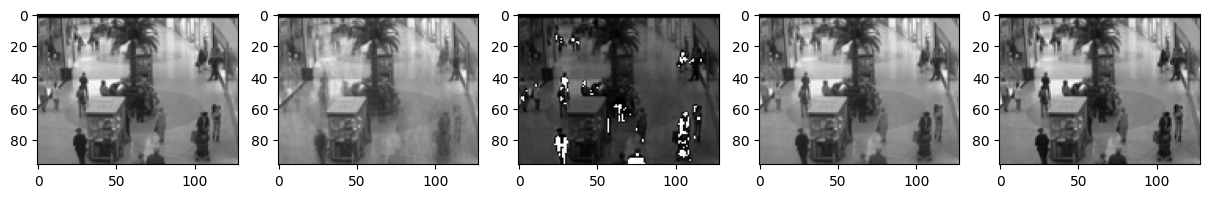

Epoch 40, loss-APG = 30239284.933, loss-PG = 36749139.539:  80%|████████  | 40/50 [01:08<00:16,  1.63s/it]

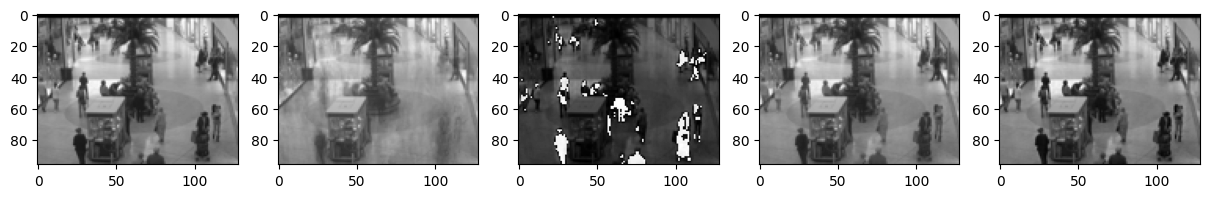

Epoch 49, loss-APG = 27930635.066, loss-PG = 36355313.116: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


In [18]:
pg = PG(D=D, L_f=L_f, mu=mu, lamda=lamda, prox=Prox)
apg = APG(D=D, L_f=L_f, mu=mu, lamda=lamda, prox=Prox)

pbar = tqdm.tqdm(range(T))
for t in pbar:
    pg.update()
    apg.update()
    pbar.set_description('Epoch {:d}, loss-APG = {:.3f}, loss-PG = {:.3f}'.format(t, apg.loss_list[t], pg.loss_list[t]))
    if t % 10 == 0 :
        show_imgs(D[0], apg.X_L[0], apg.X_S[0], pg.X_L[0], pg.X_S[0])

Select any frame to view the algorithm's performance.

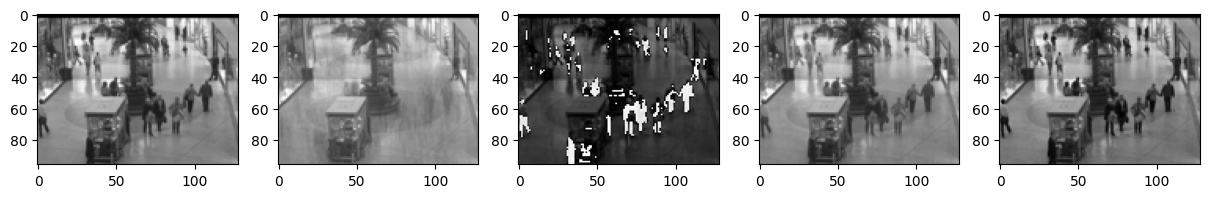

In [19]:
idx = 6
show_imgs(D[idx], apg.X_L[idx], apg.X_S[idx], pg.X_L[idx], pg.X_S[idx])

Run the following code cell to plot a comparison of the loss curves for the PG and APG algorithms.

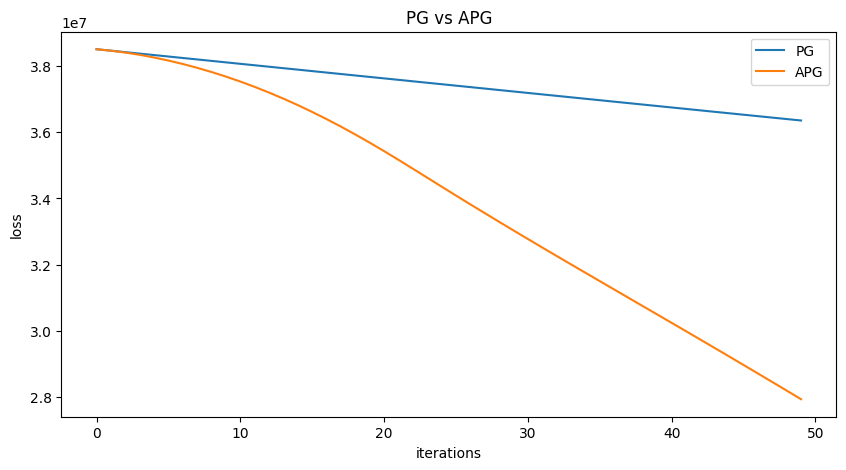

In [20]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.set_xlabel("iterations")
ax.set_ylabel("loss")
ax.set_title("PG vs APG")

ax.plot(range(T), pg.loss_list, "-", label="PG")
ax.plot(range(T), apg.loss_list, "-", label="APG")
ax.legend(loc=1)

plt.show()

Congrats! You have successfully completed all the tasks for this experiment.

For those interested in exploring further, you can make a copy of this file and experiment by running the algorithm longer or adjusting the hyperparameters to see the effects.  
However, please ensure that in the submitted file, all fixed hyperparameters ($\mu, \lambda$) remain unchanged from their original settings.


# References

[1] *Advanced Optimization*. [Link](https://www.pengzhao-ml.com/course/AOpt2024fall/)